In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [34]:
df = pd.read_csv('whites_and_reds.csv')
df = df.drop(columns=['Unnamed: 0'])
df = df.dropna(axis=0, how='any')
df = df[['points', 'taster']]
df.head()

,points,taster
1,87,Alexander Peartree
2,87,Matt Kettmann
3,87,Matt Kettmann
4,87,Anna Lee C. Iijima
5,87,Kerin O’Keefe


In [33]:
# find tasters with over 1000 reviews
taster_counts = pd.DataFrame(df['taster'].value_counts())
taster_counts = taster_counts.reset_index()
taster_counts = taster_counts.rename(columns={'taster':'ratings', 'index':'taster'})
taster_counts_over_1000 = taster_counts.loc[taster_counts['ratings'] > 1000]
tasters = taster_counts_over_1000['taster'].tolist()
tasters.sort()

In [43]:
# find averages for tasters with over 1000 reviews
ave_ratings = []
for taster in tasters:
    test_df = df.loc[df['taster'] == taster]
    test_rating = test_df['points'].mean()#.round(3)
    results_list = {'taster': taster, 'average rating': test_rating}
    ave_ratings.append(results_list)
ave_ratings_df = pd.DataFrame(ave_ratings).round(3)
ave_ratings_df = ave_ratings_df[['taster', 'average rating']]
ave_ratings_df

,taster,average rating
0,Anna Lee C. Iijima,88.796
1,Anne Krebiehl MW,91.202
2,Jim Gordon,88.433
3,Joe Czerwinski,88.155
4,Kerin O’Keefe,88.879
5,Matt Kettmann,90.237
6,Michael Schachner,86.518
7,Paul Gregutt,89.204
8,Roger Voss,89.231
9,Sean P. Sullivan,87.915


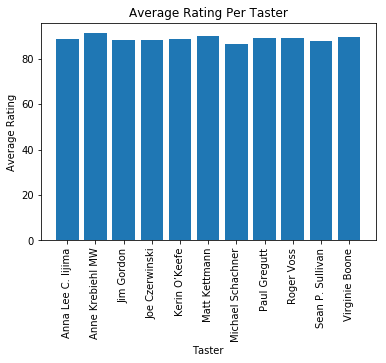

In [53]:
# bar chart for average points per taster
x_axis = np.arange(len(tasters))
plt.bar(ave_ratings_df['taster'], ave_ratings_df['average rating'])
plt.xticks(rotation = 'vertical')
plt.title('Average Rating Per Taster')
plt.xlabel('Taster')
plt.ylabel('Average Rating')
plt.show()

In [11]:
#sentiment analysis on tasters
#get compound points

In [ ]:
#compound vs. average points
#scatter